# Bank Marketing in python using h2o AutoML

More info on H2O AutoML at https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html

Import the required packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [2]:
from teradataml.dataframe.copy_to import copy_to_sql
from teradataml.context.context import get_connection
from teradataml.dataframe.dataframe import DataFrame
from teradataml import create_context
import getpass
import h2o
from h2o.automl import H2OAutoML

Replace your cluster details for your user, password, host and database.

In [3]:
engine = create_context(host="3.238.151.85", username="AOA_DEMO", password=getpass.getpass("password"))

password ··········


Load and inspect the dataset

In [4]:
dataset = DataFrame("bank_marketing_data").to_pandas()
# Visualise a table with the first rows of the dataset, to
# better understand the data format
dataset.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


Check for correlations

In [5]:
corr = dataset.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
corr

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
age,1.000000,0.166402,-0.007715,-0.045936,-0.007067,0.016128,-0.111345,-0.002402,0.050737,0.023363,0.035760,0.026622,-0.010558,0.036239,0.012112,0.045800,0.065228
job,0.166402,1.000000,-0.012186,-0.088132,-0.002168,-0.015648,-0.160040,0.001375,0.024281,0.005493,0.067786,-0.020892,-0.036376,0.024443,0.022966,0.047513,0.068978
marital,-0.007715,-0.012186,1.000000,0.090907,0.049837,-0.026206,-0.027397,-0.014321,-0.031768,0.025010,-0.009086,0.008537,-0.021882,0.009266,-0.001322,-0.000989,0.061242
education,-0.045936,-0.088132,0.090907,1.000000,-0.010534,0.011534,-0.087070,-0.054086,-0.110384,-0.010523,0.072546,-0.012168,0.005049,0.025968,0.027182,0.045689,0.042987
default,-0.007067,-0.002168,0.049837,-0.010534,1.000000,-0.022277,0.006881,0.063994,-0.006654,0.010775,0.013052,-0.039377,-0.012759,-0.028827,-0.028712,-0.031354,0.001303
balance,0.016128,-0.015648,-0.026206,0.011534,-0.022277,1.000000,0.025923,-0.016647,0.018605,-0.007546,-0.012901,0.139572,-0.022156,0.078316,-0.001406,0.006034,0.031489
housing,-0.111345,-0.160040,-0.027397,-0.087070,0.006881,0.025923,1.000000,0.018451,0.097917,-0.048346,-0.300032,0.020312,-0.010403,0.055139,0.046341,0.006302,-0.104683
loan,-0.002402,0.001375,-0.014321,-0.054086,0.063994,-0.016647,0.018451,1.000000,-0.008376,0.049655,0.083930,-0.011070,0.006911,-0.020633,-0.026135,-0.053685,-0.070517
contact,0.050737,0.024281,-0.031768,-0.110384,-0.006654,0.018605,0.097917,-0.008376,1.000000,-0.004404,-0.250411,0.018738,0.032347,-0.132054,-0.123530,-0.149290,-0.082229
day,0.023363,0.005493,0.025010,-0.010523,0.010775,-0.007546,-0.048346,0.049655,-0.004404,1.000000,0.092859,0.003150,0.049538,-0.028044,-0.028344,-0.018421,0.024205


Lets compare the age of the subscribers

67

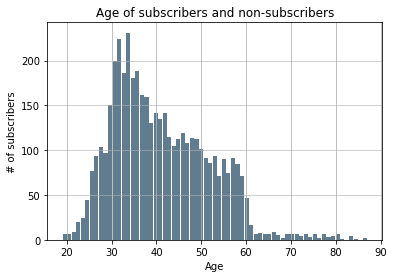

In [6]:
num_bins = dataset['age'].unique().size
dataset['age'].plot.hist(grid=True, bins=num_bins, rwidth=0.9, color='#607c8e')
plt.title('Age of subscribers and non-subscribers')
plt.xlabel('Age')
plt.ylabel('# of subscribers')
plt.grid(axis='y', alpha=0.75)
num_bins

In the histogram above we can see that there is one customer age that is significantly more prevalent than others.

Now we will visualize subscriber percentage by education level, marital status, occupation, and age:

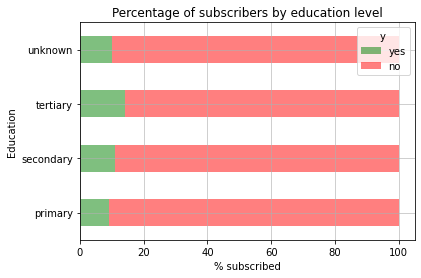

In [7]:
### subscriber % by education level
yn = dataset.groupby(['education', 'y']).size().reset_index(name='counts')
yed = dataset.groupby(['education']).size().reset_index(name='counts')
jed = yn.set_index('education').join(yed.set_index('education'), on='education', how='left', lsuffix='_caller', rsuffix='_other')
jed = jed.assign(perc = (jed['counts_caller']/jed['counts_other']) * 100)
jed = jed.round()
jed = jed.sort_values('y', ascending=True).pivot(columns='y', values='perc')
jed[['yes','no']].plot.barh(stacked=True, color=['Green','Red'], alpha=0.5)
plt.title('Percentage of subscribers by education level')
plt.ylabel('Education')
plt.xlabel('% subscribed')
plt.grid(alpha=0.75)


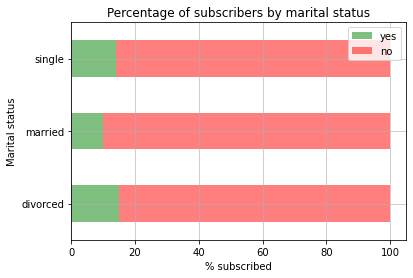

In [8]:
### subscriber % by marital status
yn = dataset.groupby(['marital', 'y']).size().reset_index(name='counts')
yed = dataset.groupby(['marital']).size().reset_index(name='counts')
jed = yn.set_index('marital').join(yed.set_index('marital'), on='marital', how='left', lsuffix='_caller', rsuffix='_other')
jed = jed.assign(perc = (jed['counts_caller']/jed['counts_other']) * 100)
jed = jed.round()
jed = jed.sort_values('y', ascending=True).pivot(columns='y', values='perc')
jed[['yes','no']].plot.barh(stacked=True, color=['Green','Red'], alpha=0.5)
plt.title('Percentage of subscribers by marital status')
plt.ylabel('Marital status')
plt.xlabel('% subscribed')
plt.legend()
plt.grid(alpha=0.75)

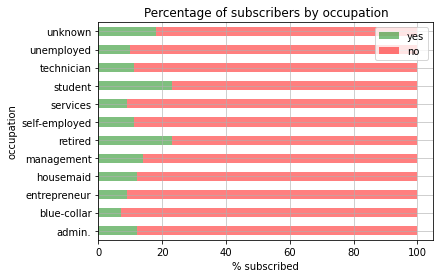

In [9]:
### subscriber by job type
yn = dataset[['job','y']].groupby(['job','y']).size().reset_index(name='counts')
yed = dataset.groupby(['job']).size().reset_index(name='counts')
jed = yn.set_index('job').join(yed.set_index('job'), on='job', how='left', lsuffix='_caller', rsuffix='_other')
jed = jed.assign(perc = (jed['counts_caller']/jed['counts_other']) * 100)
jed = jed.round()
jed = jed.sort_values('y', ascending=True).pivot(columns='y', values='perc')
jed[['yes','no']].plot.barh(stacked=True, color=['Green','Red'], alpha=0.5)
plt.title('Percentage of subscribers by occupation')
plt.ylabel('occupation')
plt.xlabel('% subscribed')
plt.legend()
plt.grid(alpha=0.75)

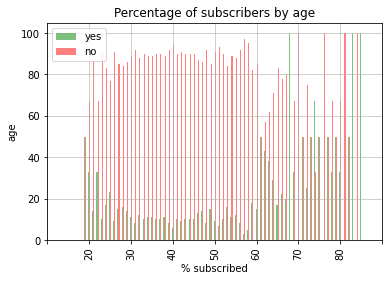

In [10]:
### subscriber by age
yn = dataset[['age','y']].groupby(['age','y']).size().reset_index(name='counts')
yed = dataset.groupby(['age']).size().reset_index(name='counts')
jed = yn.set_index('age').join(yed.set_index('age'), on='age', how='left', lsuffix='_caller', rsuffix='_other')
jed = jed.assign(perc = (jed['counts_caller']/jed['counts_other']) * 100)
jed = jed.round()
jed = jed.sort_values('y', ascending=True).pivot(columns='y', values='perc')
jed[['yes','no']].plot.bar(color=['Green','Red'], alpha=0.5)
plt.title('Percentage of subscribers by age')
plt.ylabel('age')
plt.xlabel('% subscribed')
plt.legend()
plt.xticks([-9,1,11,21,31,41,51,61,71])
plt.grid(alpha=0.75)

Upon completing the intial exploratory data analysis, I uploaded the dataset to H2O to run it through a GBM model. The model was trained on eight of the columns in the dataset: age, job, marital, education, default, balance, housing, loan

In [11]:
dataset = DataFrame("bank_marketing_data").select(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'y'])
dataset.head()

   age       job marital  education default balance housing loan    y
0   19   student  single    unknown      no       0      no   no   no
1   20   student  single  secondary      no     502      no   no  yes
2   20   student  single  secondary      no     291      no   no   no
3   20   student  single  secondary      no    1191      no   no   no
4   21  services  single  secondary      no     361      no   no   no
5   21  services  single  secondary      no    1903     yes   no   no
6   21   student  single  secondary      no       6      no   no   no
7   19   student  single  secondary      no     302      no   no  yes
8   19   student  single    unknown      no    1169      no   no   no
9   19   student  single    primary      no     103      no   no  yes

Now we must initialize h2o cluster (locally) and prepare the training dataset

In [12]:
h2o.init()
dataset_hf=h2o.H2OFrame(dataset.to_pandas())

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_292"; OpenJDK Runtime Environment (build 1.8.0_292-8u292-b10-0ubuntu1~20.04-b10); OpenJDK 64-Bit Server VM (build 25.292-b10, mixed mode)
  Starting server from /opt/conda/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp0jeq73cm
  JVM stdout: /tmp/tmp0jeq73cm/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp0jeq73cm/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,17 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,11 days
H2O_cluster_name:,H2O_from_python_unknownUser_4sl9n3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,866 Mb
H2O_cluster_total_cores:,6
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


We split the training dataset

In [13]:
train,test = dataset_hf.split_frame(ratios=[.7])

Identify predictors and response

In [14]:
x = train.columns
y = 'y'
x.remove(y)

For binary classification, response should be a factor

In [15]:
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

Run AutoML for 20 base models

In [16]:
aml = H2OAutoML(max_models=20, seed=1)
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_8_AutoML_1_20211018_165122

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.0863640250789305
RMSE: 0.2938775681792173
LogLoss: 0.29201533273085384
Null degrees of freedom: 3164
Residual degrees of freedom: 3159
Null deviance: 2279.2468166247018
Residual deviance: 1848.4570561863047
AIC: 1860.4570561863047
AUC: 0.8994202906978997
AUCPR: 0.557202984882787
Gini: 0.7988405813957995

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15303302863933296: 


,,no,yes,Error,Rate
0,no,2521.0,275.0,0.0984,(275.0/2796.0)
1,yes,117.0,252.0,0.3171,(117.0/369.0)
2,Total,2638.0,527.0,0.1239,(392.0/3165.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.153033,0.562500,156.0
1,max f2,0.133068,0.674107,187.0
2,max f0point5,0.194072,0.547156,107.0
3,max accuracy,0.238408,0.900474,71.0
4,max precision,0.501391,1.000000,0.0
5,max recall,0.072970,1.000000,321.0
6,max specificity,0.501391,1.000000,0.0
7,max absolute_mcc,0.153033,0.503590,156.0
8,max min_per_class_accuracy,0.130201,0.824034,191.0
9,max mean_per_class_accuracy,0.122347,0.828688,206.0



Gains/Lift Table: Avg response rate: 11.66 %, avg score: 11.19 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010111,0.326925,6.969004,6.969004,0.812500,0.384364,0.812500,0.384364,0.070461,0.070461,596.900407,596.900407,0.068315
1,2,0.020221,0.290220,5.628811,6.298908,0.656250,0.308154,0.734375,0.346259,0.056911,0.127371,462.881098,529.890752,0.121291
2,3,0.030016,0.261258,5.533700,6.049208,0.645161,0.272789,0.705263,0.322285,0.054201,0.181572,453.370050,504.920839,0.171558
3,4,0.040126,0.242868,5.092734,5.808207,0.593750,0.251179,0.677165,0.304368,0.051491,0.233062,409.273374,480.820690,0.218399
4,5,0.050237,0.228296,5.360772,5.718157,0.625000,0.235123,0.666667,0.290432,0.054201,0.287263,436.077236,471.815718,0.268307
5,6,0.100158,0.180847,3.691469,4.708010,0.430380,0.201252,0.548896,0.245983,0.184282,0.471545,269.146856,370.800954,0.420400
6,7,0.150079,0.157727,3.311464,4.243475,0.386076,0.167976,0.494737,0.220035,0.165312,0.636856,231.146444,324.347454,0.551019
7,8,0.200000,0.143788,2.117166,3.712737,0.246835,0.150595,0.432859,0.202703,0.105691,0.742547,111.716579,271.273713,0.614150
8,9,0.300158,0.121471,1.352876,2.925289,0.157729,0.131378,0.341053,0.178903,0.135501,0.878049,35.287630,192.528883,0.654158
9,10,0.400000,0.108123,0.434290,2.303523,0.050633,0.114442,0.268562,0.162813,0.043360,0.921409,-56.570958,130.352304,0.590222




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.09978275786883208
RMSE: 0.3158840892935763
LogLoss: 0.34612146404549615
Null degrees of freedom: 3164
Residual degrees of freedom: 3159
Null deviance: 2279.3850083222105
Residual deviance: 2190.9488674079907
AIC: 2202.9488674079907
AUC: 0.6380819870430464
AUCPR: 0.2017661657145629
Gini: 0.27616397408609283

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15981225052445608: 


,,no,yes,Error,Rate
0,no,2404.0,392.0,0.1402,(392.0/2796.0)
1,yes,250.0,119.0,0.6775,(250.0/369.0)
2,Total,2654.0,511.0,0.2028,(642.0/3165.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.159812,0.270455,144.0
1,max f2,0.092799,0.418213,282.0
2,max f0point5,0.176790,0.269733,117.0
3,max accuracy,0.360249,0.883728,4.0
4,max precision,0.360249,0.600000,4.0
5,max recall,0.042505,1.000000,387.0
6,max specificity,0.407893,0.999642,0.0
7,max absolute_mcc,0.176790,0.171288,117.0
8,max min_per_class_accuracy,0.116243,0.590786,225.0
9,max mean_per_class_accuracy,0.120655,0.595168,215.0



Gains/Lift Table: Avg response rate: 11.66 %, avg score: 11.67 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010111,0.297836,3.216463,3.216463,0.375000,0.329015,0.375000,0.329015,0.032520,0.032520,221.646341,221.646341,0.025367
1,2,0.020221,0.261672,2.412348,2.814405,0.281250,0.280828,0.328125,0.304921,0.024390,0.056911,141.234756,181.440549,0.041531
2,3,0.030016,0.239837,2.490165,2.708601,0.290323,0.249566,0.315789,0.286858,0.024390,0.081301,149.016522,170.860077,0.058053
3,4,0.040126,0.224514,1.072154,2.296268,0.125000,0.232406,0.267717,0.273138,0.010840,0.092141,7.215447,129.626784,0.058879
4,5,0.050237,0.213407,2.412348,2.319630,0.281250,0.219029,0.270440,0.262248,0.024390,0.116531,141.234756,131.962980,0.075043
5,6,0.100158,0.181438,2.280025,2.299890,0.265823,0.195389,0.268139,0.228924,0.113821,0.230352,128.002470,129.988972,0.147377
6,7,0.150079,0.164000,1.357158,1.986307,0.158228,0.171370,0.231579,0.209780,0.067751,0.298103,35.715756,98.630723,0.167559
7,8,0.200000,0.151114,1.031440,1.747967,0.120253,0.156802,0.203791,0.196556,0.051491,0.349593,3.143974,74.796748,0.169336
8,9,0.300158,0.131847,1.082301,1.525845,0.126183,0.140684,0.177895,0.177912,0.108401,0.457995,8.230104,52.584510,0.178667
9,10,0.400000,0.118670,1.058583,1.409214,0.123418,0.125082,0.164297,0.164726,0.105691,0.563686,5.858290,40.921409,0.185288


View the AutoML Leaderboard

In [17]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_8_AutoML_1_20211018_165122,0.638082,0.346121,0.201766,0.408854,0.315884,0.0997828
StackedEnsemble_BestOfFamily_5_AutoML_1_20211018_165122,0.636301,0.346284,0.197669,0.411329,0.31601,0.0998624
StackedEnsemble_BestOfFamily_4_AutoML_1_20211018_165122,0.632968,0.346891,0.199667,0.398899,0.316047,0.0998858
GBM_1_AutoML_1_20211018_165122,0.632705,0.347605,0.192872,0.413634,0.316487,0.100164
XGBoost_grid_1_AutoML_1_20211018_165122_model_2,0.6317,0.354844,0.192458,0.40059,0.319325,0.101968
XRT_1_AutoML_1_20211018_165122,0.630732,0.347815,0.191228,0.409141,0.316709,0.100304
StackedEnsemble_BestOfFamily_2_AutoML_1_20211018_165122,0.630728,0.34783,0.19332,0.406466,0.316457,0.100145
StackedEnsemble_BestOfFamily_3_AutoML_1_20211018_165122,0.630417,0.347256,0.195657,0.411833,0.316237,0.100006
XGBoost_grid_1_AutoML_1_20211018_165122_model_3,0.629868,0.360485,0.19163,0.400081,0.321096,0.103103
StackedEnsemble_AllModels_1_AutoML_1_20211018_165122,0.629832,0.347564,0.196107,0.402656,0.316333,0.100067


The leader model is stored here

In [18]:
model=aml.leader
model

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_8_AutoML_1_20211018_165122

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.0863640250789305
RMSE: 0.2938775681792173
LogLoss: 0.29201533273085384
Null degrees of freedom: 3164
Residual degrees of freedom: 3159
Null deviance: 2279.2468166247018
Residual deviance: 1848.4570561863047
AIC: 1860.4570561863047
AUC: 0.8994202906978997
AUCPR: 0.557202984882787
Gini: 0.7988405813957995

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15303302863933296: 


,,no,yes,Error,Rate
0,no,2521.0,275.0,0.0984,(275.0/2796.0)
1,yes,117.0,252.0,0.3171,(117.0/369.0)
2,Total,2638.0,527.0,0.1239,(392.0/3165.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.153033,0.562500,156.0
1,max f2,0.133068,0.674107,187.0
2,max f0point5,0.194072,0.547156,107.0
3,max accuracy,0.238408,0.900474,71.0
4,max precision,0.501391,1.000000,0.0
5,max recall,0.072970,1.000000,321.0
6,max specificity,0.501391,1.000000,0.0
7,max absolute_mcc,0.153033,0.503590,156.0
8,max min_per_class_accuracy,0.130201,0.824034,191.0
9,max mean_per_class_accuracy,0.122347,0.828688,206.0



Gains/Lift Table: Avg response rate: 11.66 %, avg score: 11.19 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010111,0.326925,6.969004,6.969004,0.812500,0.384364,0.812500,0.384364,0.070461,0.070461,596.900407,596.900407,0.068315
1,2,0.020221,0.290220,5.628811,6.298908,0.656250,0.308154,0.734375,0.346259,0.056911,0.127371,462.881098,529.890752,0.121291
2,3,0.030016,0.261258,5.533700,6.049208,0.645161,0.272789,0.705263,0.322285,0.054201,0.181572,453.370050,504.920839,0.171558
3,4,0.040126,0.242868,5.092734,5.808207,0.593750,0.251179,0.677165,0.304368,0.051491,0.233062,409.273374,480.820690,0.218399
4,5,0.050237,0.228296,5.360772,5.718157,0.625000,0.235123,0.666667,0.290432,0.054201,0.287263,436.077236,471.815718,0.268307
5,6,0.100158,0.180847,3.691469,4.708010,0.430380,0.201252,0.548896,0.245983,0.184282,0.471545,269.146856,370.800954,0.420400
6,7,0.150079,0.157727,3.311464,4.243475,0.386076,0.167976,0.494737,0.220035,0.165312,0.636856,231.146444,324.347454,0.551019
7,8,0.200000,0.143788,2.117166,3.712737,0.246835,0.150595,0.432859,0.202703,0.105691,0.742547,111.716579,271.273713,0.614150
8,9,0.300158,0.121471,1.352876,2.925289,0.157729,0.131378,0.341053,0.178903,0.135501,0.878049,35.287630,192.528883,0.654158
9,10,0.400000,0.108123,0.434290,2.303523,0.050633,0.114442,0.268562,0.162813,0.043360,0.921409,-56.570958,130.352304,0.590222




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.09978275786883208
RMSE: 0.3158840892935763
LogLoss: 0.34612146404549615
Null degrees of freedom: 3164
Residual degrees of freedom: 3159
Null deviance: 2279.3850083222105
Residual deviance: 2190.9488674079907
AIC: 2202.9488674079907
AUC: 0.6380819870430464
AUCPR: 0.2017661657145629
Gini: 0.27616397408609283

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15981225052445608: 


,,no,yes,Error,Rate
0,no,2404.0,392.0,0.1402,(392.0/2796.0)
1,yes,250.0,119.0,0.6775,(250.0/369.0)
2,Total,2654.0,511.0,0.2028,(642.0/3165.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.159812,0.270455,144.0
1,max f2,0.092799,0.418213,282.0
2,max f0point5,0.176790,0.269733,117.0
3,max accuracy,0.360249,0.883728,4.0
4,max precision,0.360249,0.600000,4.0
5,max recall,0.042505,1.000000,387.0
6,max specificity,0.407893,0.999642,0.0
7,max absolute_mcc,0.176790,0.171288,117.0
8,max min_per_class_accuracy,0.116243,0.590786,225.0
9,max mean_per_class_accuracy,0.120655,0.595168,215.0



Gains/Lift Table: Avg response rate: 11.66 %, avg score: 11.67 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010111,0.297836,3.216463,3.216463,0.375000,0.329015,0.375000,0.329015,0.032520,0.032520,221.646341,221.646341,0.025367
1,2,0.020221,0.261672,2.412348,2.814405,0.281250,0.280828,0.328125,0.304921,0.024390,0.056911,141.234756,181.440549,0.041531
2,3,0.030016,0.239837,2.490165,2.708601,0.290323,0.249566,0.315789,0.286858,0.024390,0.081301,149.016522,170.860077,0.058053
3,4,0.040126,0.224514,1.072154,2.296268,0.125000,0.232406,0.267717,0.273138,0.010840,0.092141,7.215447,129.626784,0.058879
4,5,0.050237,0.213407,2.412348,2.319630,0.281250,0.219029,0.270440,0.262248,0.024390,0.116531,141.234756,131.962980,0.075043
5,6,0.100158,0.181438,2.280025,2.299890,0.265823,0.195389,0.268139,0.228924,0.113821,0.230352,128.002470,129.988972,0.147377
6,7,0.150079,0.164000,1.357158,1.986307,0.158228,0.171370,0.231579,0.209780,0.067751,0.298103,35.715756,98.630723,0.167559
7,8,0.200000,0.151114,1.031440,1.747967,0.120253,0.156802,0.203791,0.196556,0.051491,0.349593,3.143974,74.796748,0.169336
8,9,0.300158,0.131847,1.082301,1.525845,0.126183,0.140684,0.177895,0.177912,0.108401,0.457995,8.230104,52.584510,0.178667
9,10,0.400000,0.118670,1.058583,1.409214,0.123418,0.125082,0.164297,0.164726,0.105691,0.563686,5.858290,40.921409,0.185288


Now we evaluate the predictions against the test dataframe.

In [19]:
preds=model.predict(test)
preds.head()

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


predict,no,yes
no,0.939925,0.0600751
no,0.922106,0.0778943
no,0.911545,0.0884546
no,0.954111,0.0458887
no,0.853257,0.146743
no,0.867883,0.132117
yes,0.812534,0.187466
no,0.916652,0.0833476
no,0.877966,0.122034
no,0.876775,0.123225


Evaluate performance

In [20]:
perf=model.model_performance()
perf


ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.0863640250789305
RMSE: 0.2938775681792173
LogLoss: 0.29201533273085384
Null degrees of freedom: 3164
Residual degrees of freedom: 3159
Null deviance: 2279.2468166247018
Residual deviance: 1848.4570561863047
AIC: 1860.4570561863047
AUC: 0.8994202906978997
AUCPR: 0.557202984882787
Gini: 0.7988405813957995

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15303302863933296: 


,,no,yes,Error,Rate
0,no,2521.0,275.0,0.0984,(275.0/2796.0)
1,yes,117.0,252.0,0.3171,(117.0/369.0)
2,Total,2638.0,527.0,0.1239,(392.0/3165.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.153033,0.562500,156.0
1,max f2,0.133068,0.674107,187.0
2,max f0point5,0.194072,0.547156,107.0
3,max accuracy,0.238408,0.900474,71.0
4,max precision,0.501391,1.000000,0.0
5,max recall,0.072970,1.000000,321.0
6,max specificity,0.501391,1.000000,0.0
7,max absolute_mcc,0.153033,0.503590,156.0
8,max min_per_class_accuracy,0.130201,0.824034,191.0
9,max mean_per_class_accuracy,0.122347,0.828688,206.0



Gains/Lift Table: Avg response rate: 11.66 %, avg score: 11.19 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010111,0.326925,6.969004,6.969004,0.812500,0.384364,0.812500,0.384364,0.070461,0.070461,596.900407,596.900407,0.068315
1,2,0.020221,0.290220,5.628811,6.298908,0.656250,0.308154,0.734375,0.346259,0.056911,0.127371,462.881098,529.890752,0.121291
2,3,0.030016,0.261258,5.533700,6.049208,0.645161,0.272789,0.705263,0.322285,0.054201,0.181572,453.370050,504.920839,0.171558
3,4,0.040126,0.242868,5.092734,5.808207,0.593750,0.251179,0.677165,0.304368,0.051491,0.233062,409.273374,480.820690,0.218399
4,5,0.050237,0.228296,5.360772,5.718157,0.625000,0.235123,0.666667,0.290432,0.054201,0.287263,436.077236,471.815718,0.268307
5,6,0.100158,0.180847,3.691469,4.708010,0.430380,0.201252,0.548896,0.245983,0.184282,0.471545,269.146856,370.800954,0.420400
6,7,0.150079,0.157727,3.311464,4.243475,0.386076,0.167976,0.494737,0.220035,0.165312,0.636856,231.146444,324.347454,0.551019
7,8,0.200000,0.143788,2.117166,3.712737,0.246835,0.150595,0.432859,0.202703,0.105691,0.742547,111.716579,271.273713,0.614150
8,9,0.300158,0.121471,1.352876,2.925289,0.157729,0.131378,0.341053,0.178903,0.135501,0.878049,35.287630,192.528883,0.654158
9,10,0.400000,0.108123,0.434290,2.303523,0.050633,0.114442,0.268562,0.162813,0.043360,0.921409,-56.570958,130.352304,0.590222


Extract feature interactions:

In [21]:
feature_interactions=model.feature_interaction()
feature_interactions

No calculation available for this model


Explain the model

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_BestOfFamily_8_AutoML_1_20211018_165122


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1188704916175946: 


,,no,yes,Error,Rate
0,no,857.0,347.0,0.2882,(347.0/1204.0)
1,yes,75.0,77.0,0.4934,(75.0/152.0)
2,Total,932.0,424.0,0.3112,(422.0/1356.0)


# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

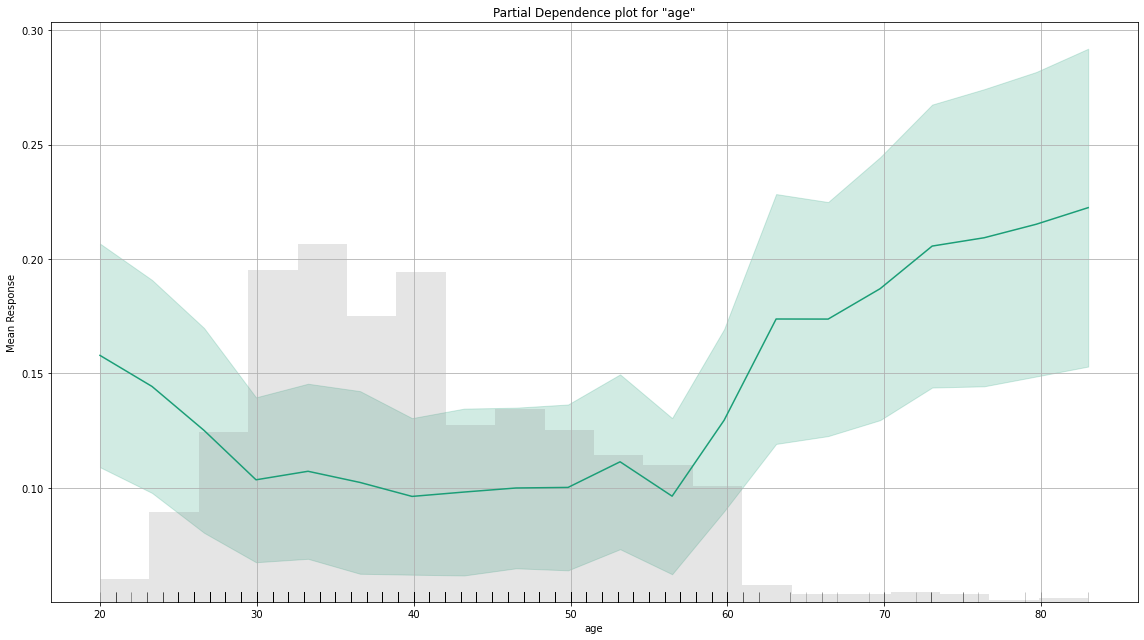

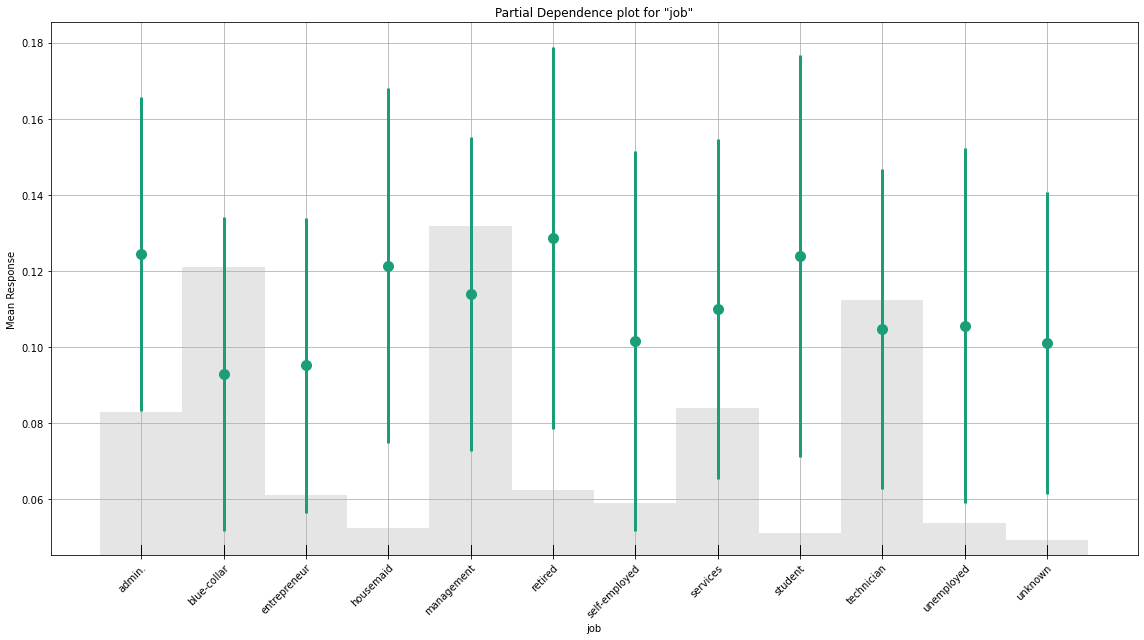

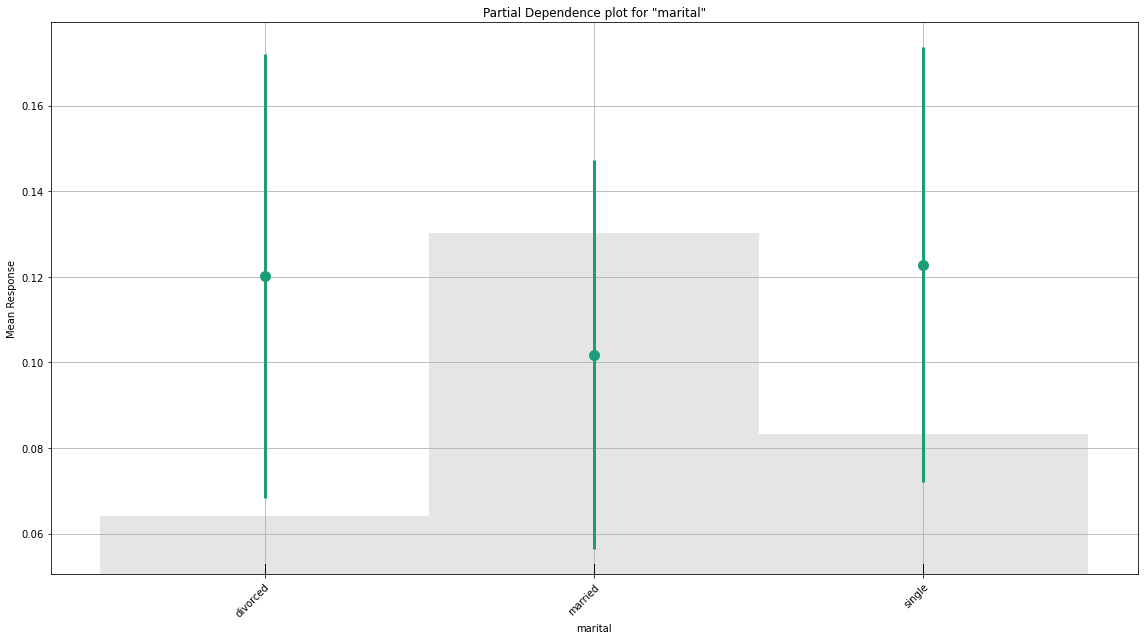

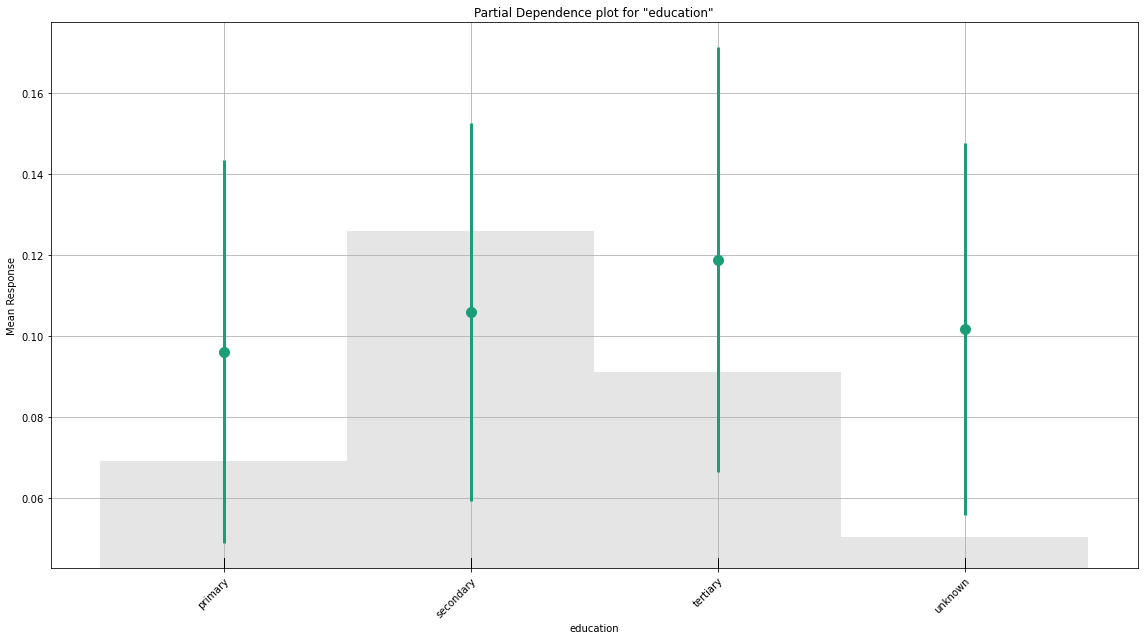

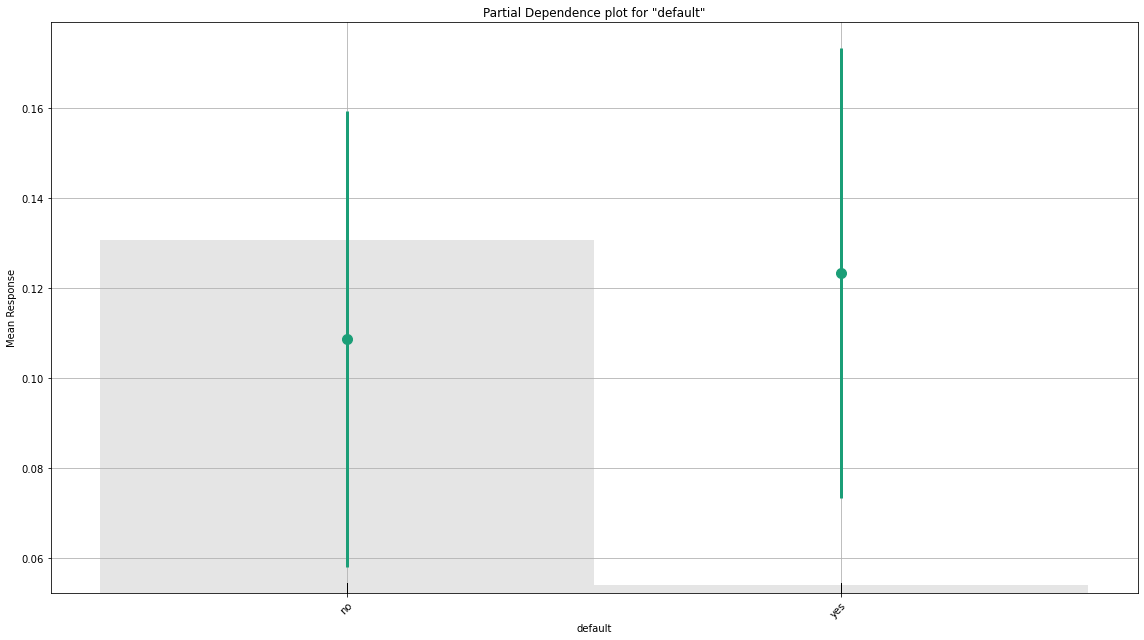

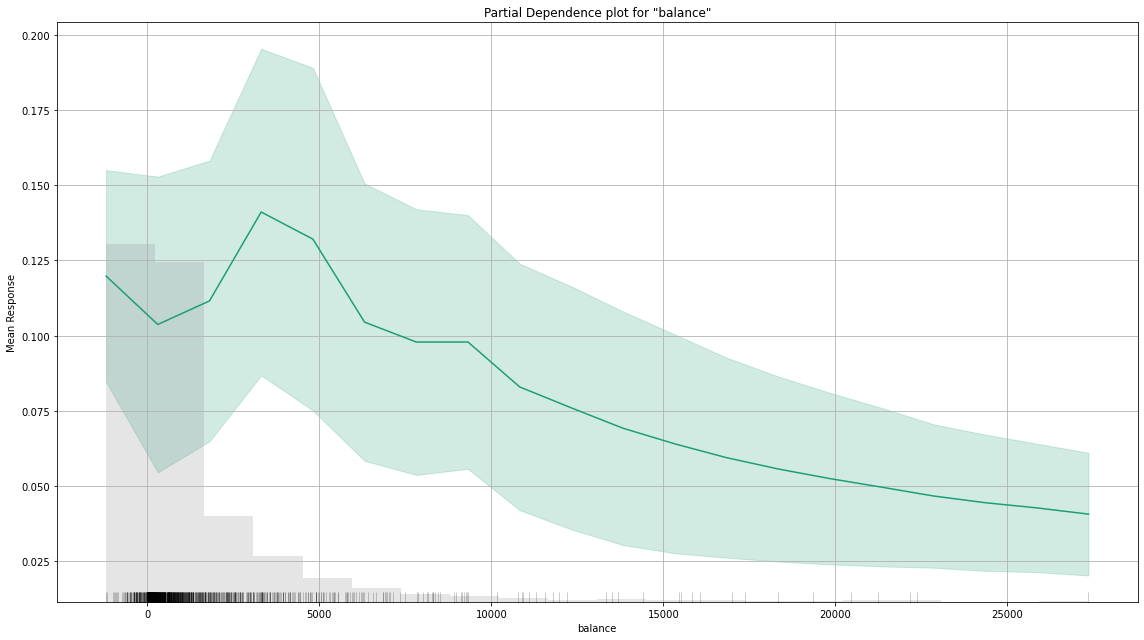

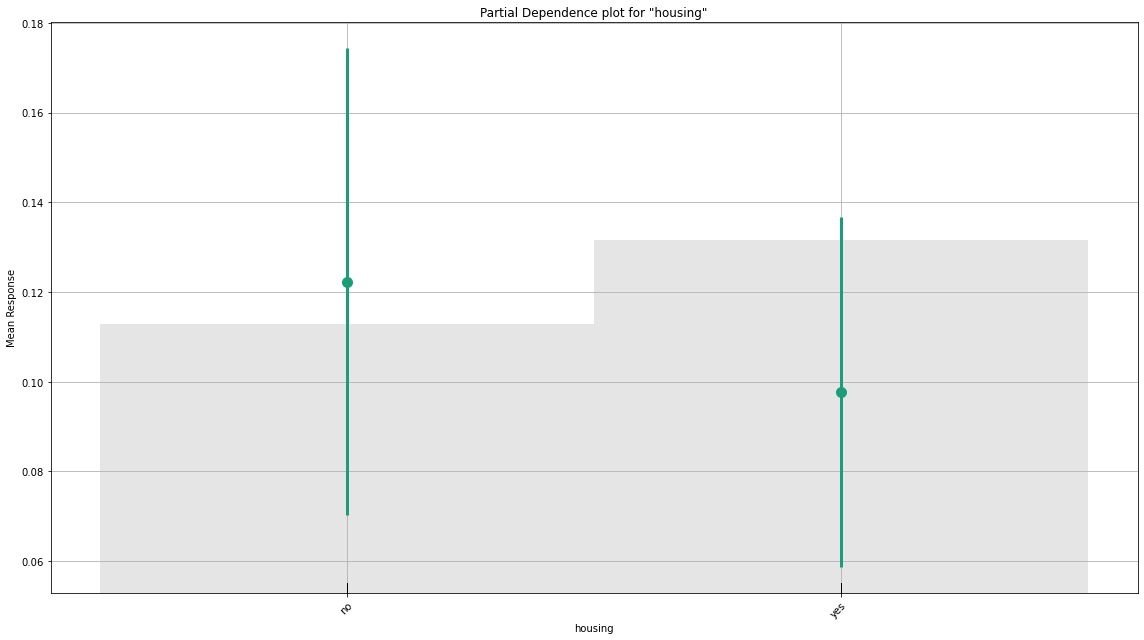

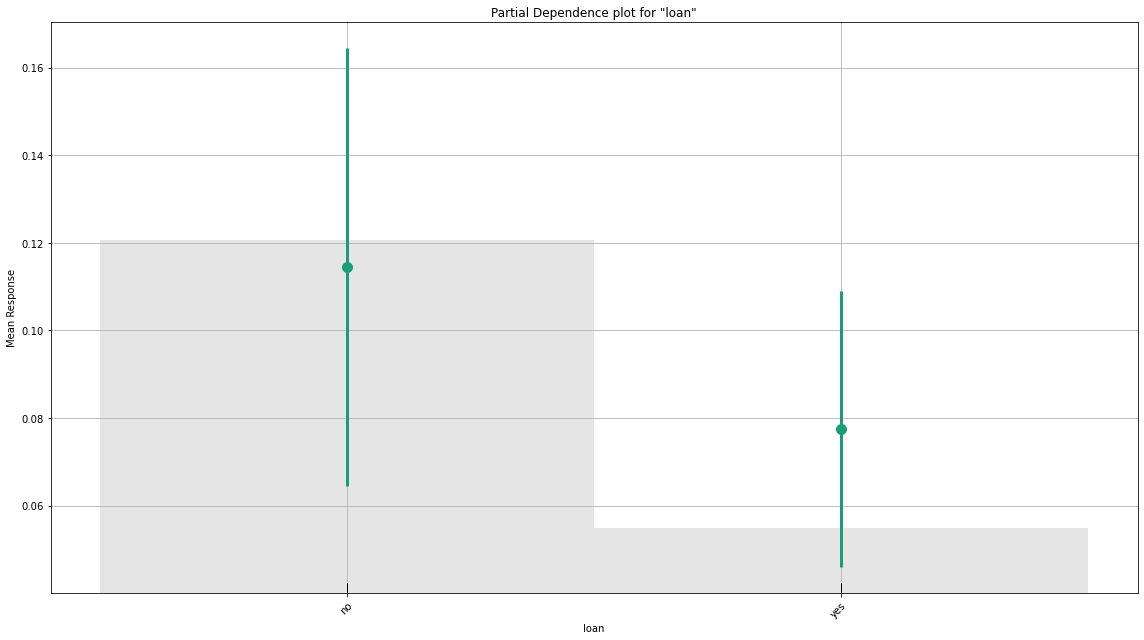

In [22]:
exm=model.explain(test)

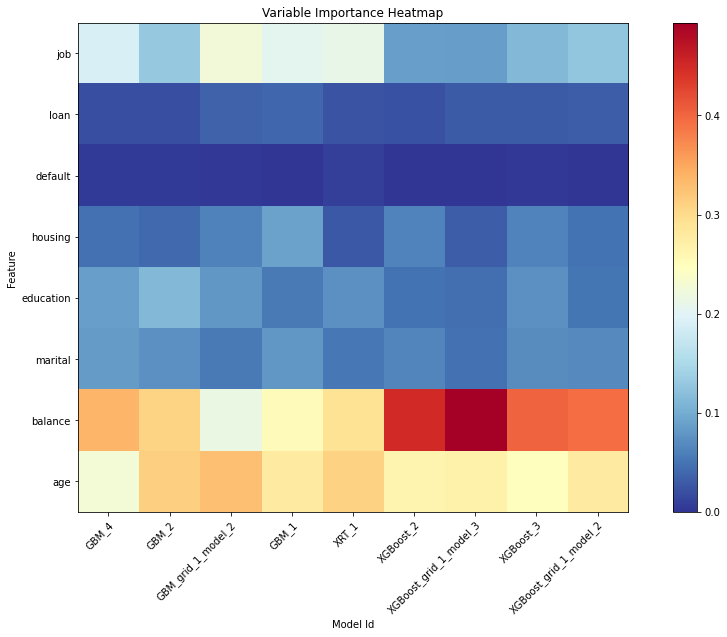

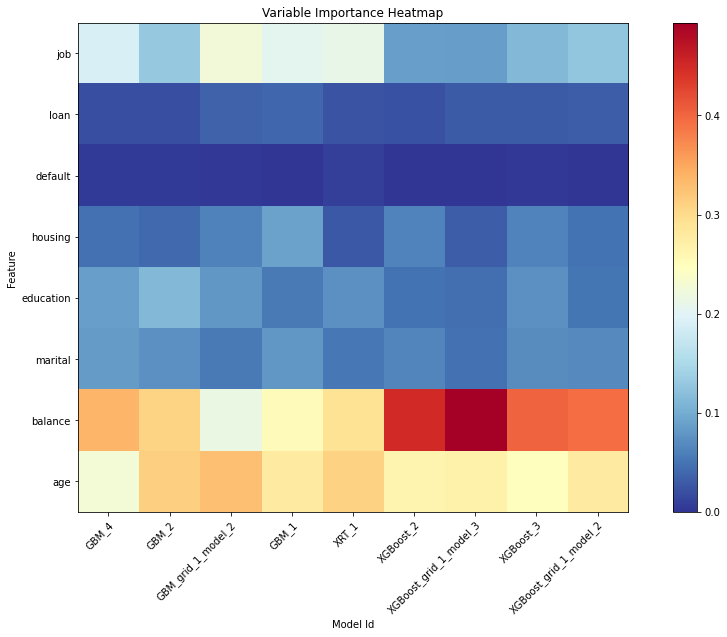

In [24]:
aml.varimp_heatmap()

In [23]:
model.varimp(True)

In [46]:
gbm = aml.get_best_model(algorithm="gbm")
fi = gbm.varimp(True)
type(fi)
fix = fi[['variable','scaled_importance']]
fis = fix.to_dict('records')
fid = {v['variable']:v['scaled_importance'] for (k,v) in enumerate(fis)}
fid

{'age': 1.0,
 'balance': 0.9038955529783794,
 'job': 0.735898665575921,
 'housing': 0.31895030308571926,
 'marital': 0.28327050022189343,
 'education': 0.1972393918592983,
 'loan': 0.14256616494799582,
 'default': 0.0}

Get the variable importance plot

In [25]:
ra_plot = model.varimp_plot()

H2OValueError: Variable importance plot is not available for this type of model (stackedensemble).

Get the variable importance heatmap

In [ ]:
va_plot = aml.varimp_heatmap()

Get the model correlation heatmap

In [ ]:
mc_plot = aml.model_correlation_heatmap(test)

Get the shap summary plot

In [54]:
shap_plot = model.shap_summary_plot(test)

OSError: Job with key $03017f00000132d4ffffffff$_b4a5f19910a4e930cbd71371b0df441e failed with an exception: water.exceptions.H2OIllegalArgumentException: Model type StackedEnsemble doesn't support calculating Feature Contributions.
stacktrace: 
water.exceptions.H2OIllegalArgumentException: Model type StackedEnsemble doesn't support calculating Feature Contributions.
	at water.api.ModelMetricsHandler$1.compute2(ModelMetricsHandler.java:432)
	at water.H2O$H2OCountedCompleter.compute(H2O.java:1652)
	at jsr166y.CountedCompleter.exec(CountedCompleter.java:468)
	at jsr166y.ForkJoinTask.doExec(ForkJoinTask.java:263)
	at jsr166y.ForkJoinPool$WorkQueue.runTask(ForkJoinPool.java:974)
	at jsr166y.ForkJoinPool.runWorker(ForkJoinPool.java:1477)
	at jsr166y.ForkJoinWorkerThread.run(ForkJoinWorkerThread.java:104)


Get the SHAP local explanation

In [50]:
shapr_plot = model.shap_explain_row_plot(test, row_index=0)

OSError: Job with key $03017f00000132d4ffffffff$_b80674bddb57340d16079fbdce442d2 failed with an exception: water.exceptions.H2OIllegalArgumentException: Model type StackedEnsemble doesn't support calculating Feature Contributions.
stacktrace: 
water.exceptions.H2OIllegalArgumentException: Model type StackedEnsemble doesn't support calculating Feature Contributions.
	at water.api.ModelMetricsHandler$1.compute2(ModelMetricsHandler.java:432)
	at water.H2O$H2OCountedCompleter.compute(H2O.java:1652)
	at jsr166y.CountedCompleter.exec(CountedCompleter.java:468)
	at jsr166y.ForkJoinTask.doExec(ForkJoinTask.java:263)
	at jsr166y.ForkJoinPool$WorkQueue.runTask(ForkJoinPool.java:974)
	at jsr166y.ForkJoinPool.runWorker(ForkJoinPool.java:1477)
	at jsr166y.ForkJoinWorkerThread.run(ForkJoinWorkerThread.java:104)


Now lets get the model metrics based on the evaluation

In [49]:
eval_metrics=model.model_performance(test)
eval_metrics.show()


ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.09660283061934818
RMSE: 0.31080995900927655
LogLoss: 0.3378632875705173
Null degrees of freedom: 1355
Residual degrees of freedom: 1350
Null deviance: 951.833414712266
Residual deviance: 916.2852358912434
AIC: 928.2852358912434
AUC: 0.6390813516349012
AUCPR: 0.19460263855204932
Gini: 0.2781627032698024

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1188704916175946: 


,,no,yes,Error,Rate
0,no,857.0,347.0,0.2882,(347.0/1204.0)
1,yes,75.0,77.0,0.4934,(75.0/152.0)
2,Total,932.0,424.0,0.3112,(422.0/1356.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.118870,0.267361,183.0
1,max f2,0.081248,0.418502,296.0
2,max f0point5,0.189340,0.241597,62.0
3,max accuracy,0.436116,0.888643,0.0
4,max precision,0.436116,1.000000,0.0
5,max recall,0.038332,1.000000,391.0
6,max specificity,0.436116,1.000000,0.0
7,max absolute_mcc,0.118870,0.148608,183.0
8,max min_per_class_accuracy,0.106910,0.610465,218.0
9,max mean_per_class_accuracy,0.106053,0.615623,221.0



Gains/Lift Table: Avg response rate: 11.21 %, avg score: 10.89 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010324,0.311408,3.823308,3.823308,0.428571,0.357407,0.428571,0.357407,0.039474,0.039474,282.330827,282.330827,0.032829
1,2,0.020649,0.254858,1.911654,2.867481,0.214286,0.282617,0.321429,0.320012,0.019737,0.059211,91.165414,186.748120,0.043430
2,3,0.030236,0.231778,0.686235,2.175866,0.076923,0.242349,0.243902,0.295387,0.006579,0.065789,-31.376518,117.586650,0.040042
3,4,0.040560,0.219560,3.186090,2.433014,0.357143,0.225181,0.272727,0.277517,0.032895,0.098684,218.609023,143.301435,0.065462
4,5,0.050147,0.197825,2.744939,2.492647,0.307692,0.206647,0.279412,0.263968,0.026316,0.125000,174.493927,149.264706,0.084302
5,6,0.100295,0.163352,1.574303,2.033475,0.176471,0.179144,0.227941,0.221556,0.078947,0.203947,57.430341,103.347523,0.116738
6,7,0.150442,0.148015,1.574303,1.880418,0.176471,0.155196,0.210784,0.199436,0.078947,0.282895,57.430341,88.041796,0.149174
7,8,0.200590,0.135635,0.918344,1.639899,0.102941,0.141484,0.183824,0.184948,0.046053,0.328947,-8.165635,63.989938,0.144562
8,9,0.300147,0.120171,1.519883,1.600091,0.170370,0.127460,0.179361,0.165879,0.151316,0.480263,51.988304,60.009052,0.202855
9,10,0.400442,0.108612,1.049536,1.462198,0.117647,0.114422,0.163904,0.152991,0.105263,0.585526,4.953560,46.219831,0.208450


Get the confusion matrix

In [51]:
confusion = eval_metrics.confusion_matrix()
confusion


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1188704916175946: 


,,no,yes,Error,Rate
0,no,857.0,347.0,0.2882,(347.0/1204.0)
1,yes,75.0,77.0,0.4934,(75.0/152.0)
2,Total,932.0,424.0,0.3112,(422.0/1356.0)


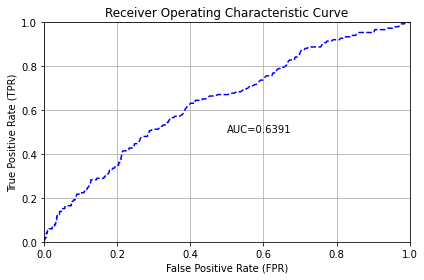

In [52]:
eval_metrics.plot(type = "roc")

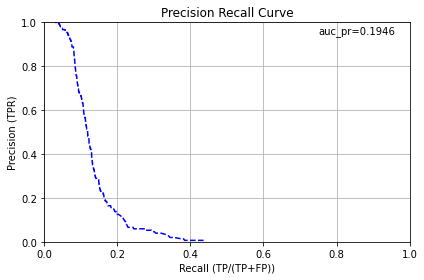

In [53]:
eval_metrics.plot(type = "pr")

In [60]:
model2 = aml.get_best_model(algorithm="gbm")

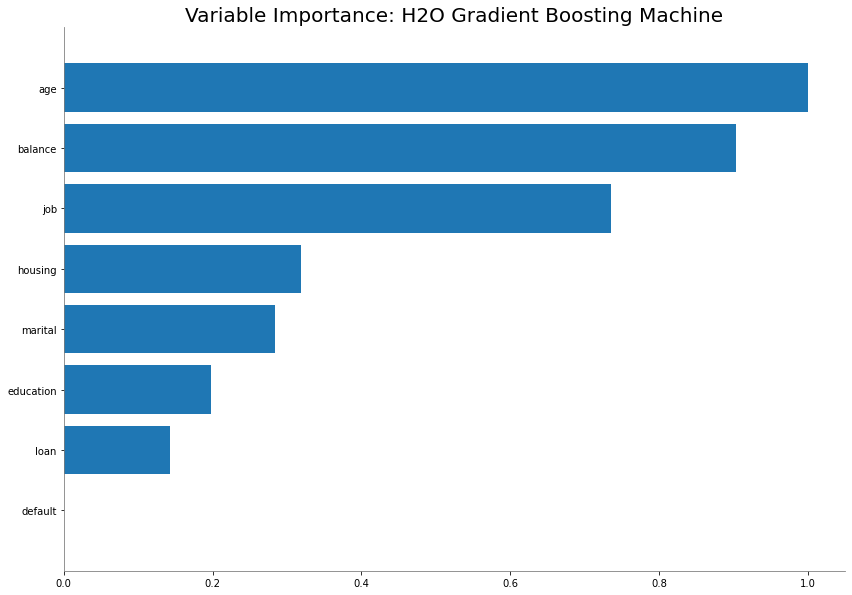

In [66]:
ra_plot = model2.varimp_plot()

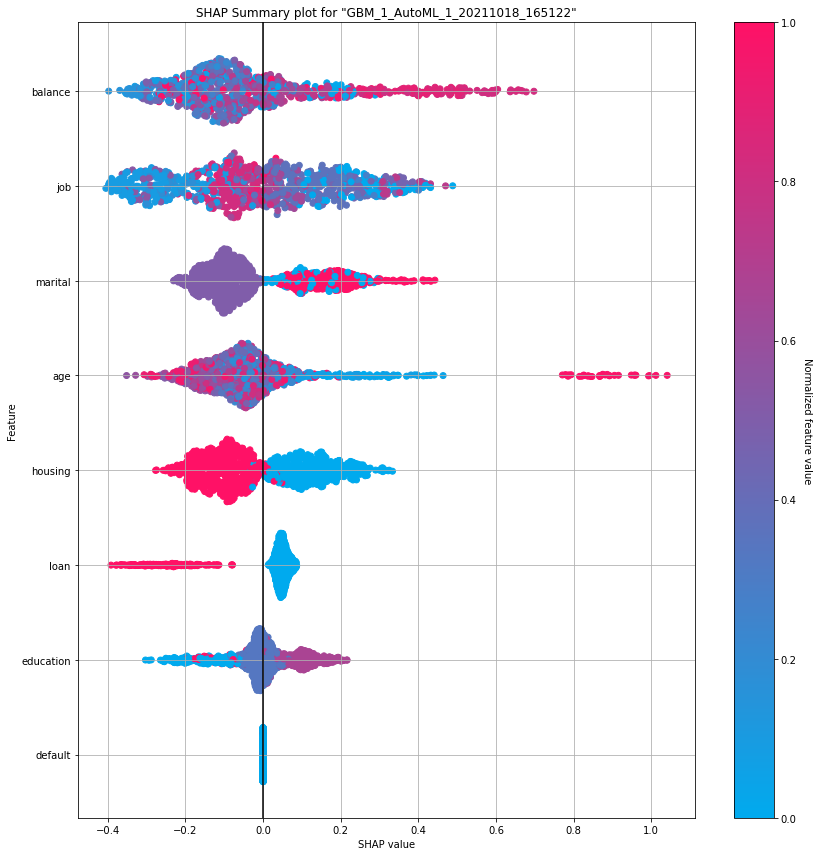

In [64]:
shap_plot = model2.shap_summary_plot(test)

In [ ]:
shapr_plot = model2.shap_explain_row_plot(test, row_index=0)

In [ ]:
learning_curve_plot = model.learning_curve_plot()

In [ ]:
learning_curve_plot = model.learning_curve_plot()

In [ ]:
evaluation = {
        'Gini': '{:.6f}'.format(eval_metrics.gini()),
        'MSE': '{:.6f}'.format(eval_metrics.mse()),
        'RMSE': '{:.6f}'.format(eval_metrics.rmse()),
        'LogLoss': '{:.6f}'.format(eval_metrics.logloss()),
        'AUC': '{:.6f}'.format(eval_metrics.auc()),
        'AUCPR': '{:.6f}'.format(eval_metrics.aucpr()),
        'Accuracy': '{:.6f}'.format(eval_metrics.accuracy()[0][1]),
        'Mean Per-Class Error': '{:.6f}'.format(eval_metrics.mean_per_class_error()[0][1]),
        'F1 score': '{:.6f}'.format(eval_metrics.F1()[0][1]),
        'Precision': '{:.6f}'.format(eval_metrics.precision()[0][1]),
        'Sensitivity': '{:.6f}'.format(eval_metrics.sensitivity()[0][1]),
        'Specificity': '{:.6f}'.format(eval_metrics.specificity()[0][1]),
        'Recall': '{:.6f}'.format(eval_metrics.recall()[0][1])
    }

In [ ]:
evaluation